# Tutorial 04: Penalized Linear Discriminant Analysis

In this tutorial, we will learn how to use penalized linear discriminant analysis (PLDA) for dimensionality reduction and classification. Not only will we use PLDA, but we will also use some of the visualization tools in the *optimaltransport* package to assess the results.

Similarly to the previous tutorial on PCA, this tutorial will not provide an in-depth discussion of PLDA and its mathematics. In short, PLDA can be considered as a trade-off between linear discriminant analysis (LDA) and principal component analysis (PCA). If LDA and PCA are unfamiliar concepts, I suggest you read [Sebastian Raschka's tutorial](http://sebastianraschka.com/Articles/2014_python_lda.html) for a good explanation of the topics. For more information about PLDA, I recommend reading the paper by [Wei Wang et al](http://imagedatascience.com/wang_prl_11.pdf). I also recommend familiarizing yourself with classifiers (e.g. LDA, SVM, logistic regression) in *scikit-learn*, since the `PLDA` class uses the same function names (e.g. `fit()` and `predict()`).

## Import Packages

As always, we need to import some useful packages. We will use the numerical Python package *Numpy* for array manipulation and *matplotlib* for plotting figures. We will also use some sample data from *scikit-learn* (*sklearn*), and compare PLDA to *sklearn*'s LDA and PCA functions. In order to use the *optimaltransport* package later, we must also add the package code to the current Python path (you can skip this step if the *optimaltransport* package has been installed via the pip package manager).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Add the optrans package to the Python path
# (change the path below to the location of the optimaltransport directory on your computer)
# Note: this step is not necessary if you have installed optimaltransport through pip.
import sys
sys.path.append('../../code/python/optimaltransport')

## Performing PLDA

Similarly to LDA, the goal of PLDA is often to project data into a lower dimensional subspace (i.e. dimensionality reduction), whilst preserving class discriminatory information. We can demonstrate this by transforming and classifying the famous "iris" dataset, originally used by Fisher in his [paper on LDA](http://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x/abstract).

The iris dataset contains measurements for 150 flowers. There are three classes of flower (setosa, versicolor, virginica), and each flower has four measurements (sepal length, sepal width, petal length, petal width). We will project the dataset from four dimensions to two dimensions, and classify the data in the resulting space.

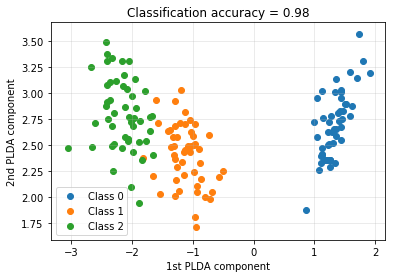

In [2]:
from optrans.decomposition import PLDA

# Load iris dataset and class labels
X, y = load_iris(return_X_y=True)

# Initialize PLDA object
plda = PLDA(alpha=1., n_components=2)

# Fit PLDA and transform the data into two dimensions
X_plda = plda.fit_transform(X, y)

# Get the classification accuracy on the training data
acc = plda.score(X, y)

# Plot the 2D space
for lab in np.unique(y):
    plt.scatter(X_plda[y==lab,0], X_plda[y==lab,1], label='Class {}'.format(lab))
plt.grid(alpha=0.3)
plt.xlabel('1st PLDA component')
plt.ylabel('2nd PLDA component')
plt.title('Classification accuracy = {:.2f}'.format(acc))
plt.legend()
plt.show()

## Comparing PLDA, LDA, and PCA

The weighting parameter $\alpha$ controls how similar PLDA is to LDA or PCA. If $\alpha = 0$, PLDA is equivalent to LDA. If $\alpha$ is very large, PLDA is equivalent to PCA. To highlight the effect that $\alpha$ has on the PLDA components, we can repeat the experiment above for different values of $\alpha$ and compare the results to *scikit-learn*'s LDA and PCA functions.

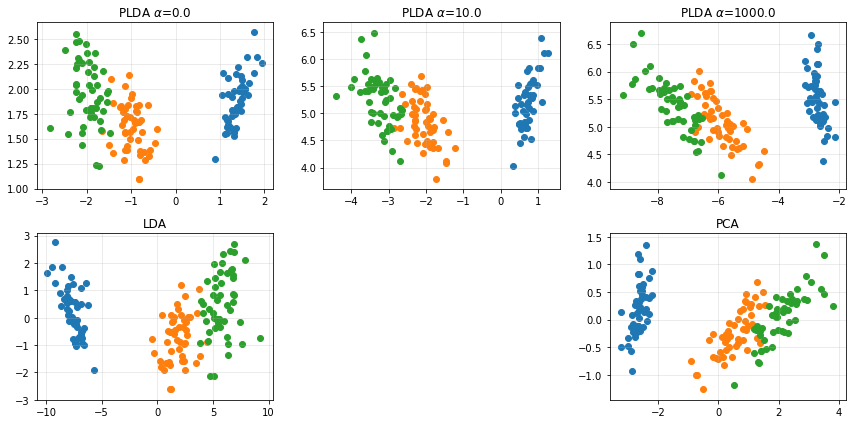

In [3]:
# Create a function to draw the scatter plot
def plot_scatter(X, y, ax):
    ax.grid(True, alpha=0.3)
    for lab in np.unique(y):
        ax.scatter(X[y==lab,0], X[y==lab,1])
    return

# Initialize the figure
fig, ax = plt.subplots(2, 3, figsize=(12,6))

# Compute PLDA using different alpha values
for i,alpha in enumerate([0.,10.,1000.]):
    # Fit and transform data using PLDA
    plda = PLDA(alpha=alpha, n_components=2)
    X_plda = plda.fit_transform(X, y)

    # Plot transformed data
    plot_scatter(X_plda, y, ax[0,i])
    ax[0,i].set_title('PLDA $\\alpha$={:.1f}'.format(alpha))
    
# For comparison, perform LDA
# Note: This should be the same as PLDA with alpha=0
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)
plot_scatter(X_lda, y, ax[1,0])
ax[1,0].set_title('LDA')

# For comparison, perform PCA
# Note: This should be the same as PLDA with very large alpha
pca = PCA()
X_pca = pca.fit_transform(X)
plot_scatter(X_pca, y, ax[1,-1])
ax[1,2].set_title('PCA')

# Ignore the bottom-center plot
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

As we can see from the figure above, when $\alpha = 0$ the PLDA and LDA results look identical (albeit with the $x$-axis flipped). Similarly, when $\alpha = 1000$ PLDA produces the same results as PCA (again, with the $x$-axis flipped).

## Combining PCA and PLDA

Peforming PLDA on the iris dataset is fairly trivial, since the number of features is small. However, to perform PLDA on a dataset with a large number of features, it may be necessary to perform PCA prior to PLDA. When solving the PLDA problem, the algorithm has to invert an $P{\times}P$ matrix, where $P$ is the number of features. If $P$ is very large, the matrix inversion operation is very computationally expensive. By performing PCA before PLDA, we can reduce the number of features in the PLDA input data, and thus make PLDA more tractable.

To demonstrate the PCA+PLDA pipeline, we must first load a sample dataset with a large number of features. We will use data from a brain PET study looking at amyloid protein in healthy volunteers and people suffering from Alzheimer's disease. The dataset comprises a 2D axial slice from the brain scans of 264 subjects, and our task is to classify the brains as healthy or diseased using PLDA.

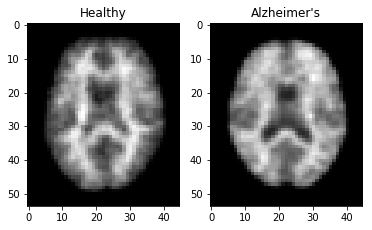

In [4]:
from optrans.datasets import adni

# Load the image data X and class labels y
fpath = '../../code/python/optimaltransport/optrans/datasets/adni_data.npz'
X, y = adni.load_data(fpath=fpath)

# Find the indices of the first healthy volunteer and first Alzheimer's patient
ind_hv = y.argmin()
ind_ad = y.argmax()

# Plot the images
_, ax = plt.subplots(1, 2)
ax[0].imshow(X[ind_hv], cmap='gray')
ax[0].set_title('Healthy')
ax[1].imshow(X[ind_ad], cmap='gray')
ax[1].set_title('Alzheimer\'s')
plt.show()

Machine learning tasks typically require a set of training data and a separate set of test data. Since our dataset does not explicitly contain training and testing data, before we begin classifying the brain images, we must split the dataset into training and test sets. For this example, we will use 80% of the data (211 images) to train the PLDA classifier, and use the remaining 20% of the data (53 images) to test test it. Moreover, the functions to fit the PCA and PLDA transforms expect the data to be 1D. As a result, we must also reshape our 2D images into 1D arrays.

In [5]:
# Reshape data into a n-by-p 2d array
n_imgs, h, w = X.shape
X = X.reshape((n_imgs,h*w))

# Split data into training and test sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

### Perform PCA Before Classification

The dimension of the images is 54${\times}$45 pixels, so our training dataset consists of 211 samples, each with 2430 features. Although it is possible to invert a 2430${\times}$2430 matrix, we don't want to waste time (and computational resources) when we don't have to. Therefore, we will use PCA to reduce the dimension of our data. The maximum number of components that can be returned by *scikit-learn*'s PCA function is determined by `min(n_samples,n_features)`. Since the number of samples in our training dataset (211) is considerably smaller than the number of features (2430), *scikit-learn*'s PCA function will significantly reduce the number of dimensions.

In [6]:
# Initialize PCA
pca = PCA()

# Learn PCA on the training data
Xtr_pca = pca.fit_transform(Xtr)

# Transform the test data accordingly
Xte_pca = pca.transform(Xte)

print("Dimensions before PCA: ", Xtr.shape[1])
print("Dimensions after PCA: ", Xtr_pca.shape[1])

Dimensions before PCA:  2430
Dimensions after PCA:  211


### Classify Data Using PLDA

Now that we have reduced the dimension of our dataset by about 90%, we can train the PLDA classifier, and then test it using our test data.

In [17]:
# Train PLDA classifier using dimension-reduced data
plda = PLDA(n_components=2, alpha=1.)
plda.fit(Xtr_pca, ytr)

# Test PLDA classifier
y_pred = plda.predict(Xte_pca)
acc = plda.score(Xte_pca, yte)

print("Classification accuracy on test data: {:.3f}".format(acc))

Classification accuracy on test data: 0.868


With only 211 training samples, a classification accuracy of 86.8% is pretty good! Furthermore, we may be able to improve this accuracy by optimizing the PLDA weighting parameters `alpha`.

### Project Data Into Lower Dimensional Space

Similarly to PCA, PLDA can project the data into a lower dimensional space. In the example above we initialized the `PLDA` object to return two components: `plda = PLDA(n_components=2, alpha=1.)`. This means that we can transform the training and test data from 211 dimensions to two dimensions, and plot the results on a scatter plot (just like the iris dataset).

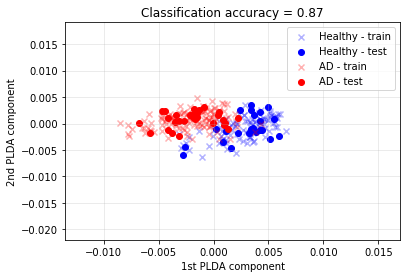

In [16]:
# Transform the training and testing data using our learned PLDA directions
Xtr_plda = plda.transform(Xtr_pca)
Xte_plda = plda.transform(Xte_pca)

# Plot the transformed data on a scatter plot
for lab,col,name in zip([0,1],['b','r'],['Healthy','AD']):
    plt.scatter(Xtr_plda[ytr==lab,0], Xtr_plda[ytr==lab,1], c=col, marker='x', alpha=0.3, label=name+' - train')
    plt.scatter(Xte_plda[yte==lab,0], Xte_plda[yte==lab,1], c=col, label=name+' - test')
plt.grid(alpha=0.3)
plt.xlabel('1st PLDA component')
plt.ylabel('2nd PLDA component')
plt.title('Classification accuracy = {:.2f}'.format(acc))
plt.legend()
plt.show()

After plotting the transformed data, we can see that the patients with Alzheimer's disease (in red) are clustered in the left of the figure, whereas healthy volunteers (in blue) are grouped together on the right.

## Modes of Variation

Another advantage of PLDA classifier is that it can be inverted. This means that it is possible to visualize the discriminatory information. For example, by plotting the images that correspond to the black dots in the figure below, we can visualize how the brain images change along the $x$-axis of our PLDA scatter plot.

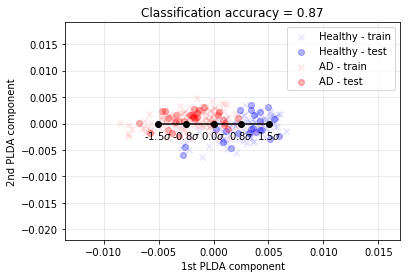

In [19]:
# Plot the transformed data on a scatter plot
for lab,col,name in zip([0,1],['b','r'],['Healthy','AD']):
    plt.scatter(Xtr_plda[ytr==lab,0], Xtr_plda[ytr==lab,1], c=col, marker='x', alpha=0.1, label=name+' - train')
    plt.scatter(Xte_plda[yte==lab,0], Xte_plda[yte==lab,1], c=col, alpha=0.3, label=name+' - test')
plt.grid(alpha=0.3)
plt.xlabel('1st PLDA component')
plt.ylabel('2nd PLDA component')
plt.title('Classification accuracy = {:.2f}'.format(acc))
plt.legend()

# Plot evenly-spaced black dots
std0 = np.sqrt(plda.explained_variance_[0])
std_range = np.linspace(-1.5,1.5,5)
std_steps = std0 * std_range
plt.plot(std0*std_range, np.zeros(5), marker='o', ls='-', c='k')
for s in std_range:
    plt.text(std0*s, -0.003, '{:.1f}$\sigma$'.format(s), ha='center', color='k', fontsize=10)
    
plt.show()

### Visualizing the Mode of Variation

By reconstructing the images corresponding the black dots, we can visualize the "mode of variation" of the first PLDA direction (component). We did something very similar in the PCA tutorial, however, in this example, we need to invert the PLDA and PCA transforms in order to recover the mode of variation in image space. Fortunately, the *optimaltransport* package has a visualization function that can keep track of the transformation pipeline and reconstruct the mode in image space: `plot_mode_image()`.

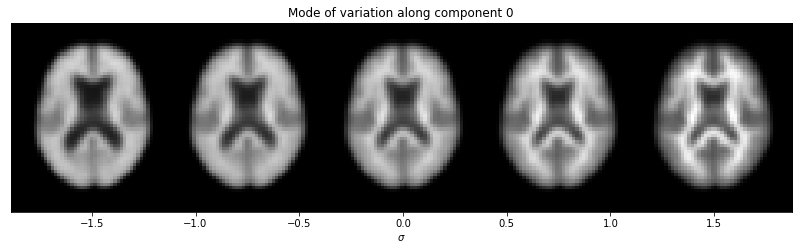

In [20]:
from optrans.visualization import plot_mode_image

ax = plot_mode_image([pca, plda], component=0, shape=(h,w), n_std=3, n_steps=5, cmap='gray', figsize=(14,4))
plt.show()

The first parameter of the `plot_mode_image()` function defines our data analysis pipeline. Since we performed PCA and then PLDA, the first parameter comprises a list of those objects: `[pca, plda]`. If we had only used PCA to analyse our data, the first input would be `[pca]`. Similarly, if we had performed PLDA without PCA, the input pipeline would be `[plda]`. We refer the reader to the *optimaltransport* documenatation for a full explanation of the `plot_mode_image()` parameters.

The figure above matches our expected mode of variation along the first PLDA component. The brain on the left-hand side of the figure corresponds to data points on the left of our scatter plot in the previous section (i.e. Alzheimer's patients). If we compare the left-most brain with our example Alzheimer's brain scan from earlier, we see that they are very similar. Moreover, if we compare the brain on the right-hand side of the figure above with our example healthy brain, they also look very similar. Therefore, we can conclude that the PLDA classifier has learned the discriminating features between the amyloid PET scans of Alzheimer's patients and healthy volunteers. This is also confirmed by the high classification accuracy (~87%).

## Data Projection

Not only can we reconstruct images along a given PLDA component, but we can also plot histograms of the data projected on to that component. Once again the *optimaltransport* package has a visualization function that can plot the data projection for us: `plot_mode_histogram()`.

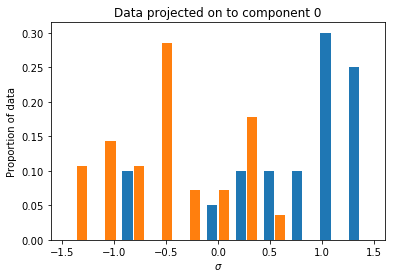

In [23]:
from optrans.visualization import plot_mode_histogram

# Plot histogram of the test data projected on to the 1st PLDA component
ax = plot_mode_histogram(Xte_plda, y=yte, component=0, decomp=plda, n_bins=11)
plt.show()

The histograms above mirror our scatter plot from earlier. The Alzheimer's data is clustered on the left of the bar chart, and the majority of the healthy volunteer data is clustered on the right of the figure.

If we want the histogram values, rather than a plot of the results, we can use the `optrans.decomposition.get_mode_histogram()` function. The visualization function that we used above just plots the output of `get_mode_histogram()`.

## The Power of Optimal Transport and PLDA

In contrast to linear signal transforms (e.g. Fourier, wavelet, PCA), transport-based transforms allow for a non-linear signal representation. This means that some non-linearly separable data classes can become linearly separable in transport space (e.g. Radon-CDT space). Without going into detail, our PET brain image classification task is a good candidate for improvement in transport space. Therefore, we will repeat the previous data analysis, but using the Radon-CDTs of our brain images rather than the images themselves. Hopefully, we will be able to improve our ~87% classification accuracy!

### Loading and Pre-Processing Data

To facilitate analysis of our brain images in transport space, I have already computed the Radon-CDTs of the images with respect to a reference image (the average brain image). Let's load the data and plot an transport map.

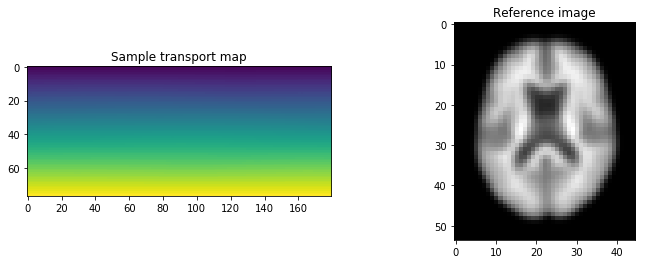

In [34]:
# Load the transport maps X and class labels y
fpath = '../../code/python/optimaltransport/optrans/datasets/'
X, y = adni.load_rcdt_maps(fpath=fpath+'adni_rcdt_maps.npz')
img0 = adni.load_img0(fpath=fpath+'adni_img0.npy')

_, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(X[0])
ax[0].set_title('Sample transport map')
ax[1].imshow(img0, cmap='gray')
ax[1].set_title('Reference image')
plt.show()

As before, in order to use PCA and PLDA functions, we have to reshape the 2D Radon-CDTs into 1D arrays. We must also split our dataset into separate training and testing sets. For a fair comparison between classification in image and classification in Radon-CDT space, we will use the same training and testing subjects as before.

In [35]:
# Reshape data into a n-by-p 2d array
n_imgs, h, w = X.shape
X = X.reshape((n_imgs,h*w))

# Split data into training and test sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

### Reduce Data Dimension Using PCA

The original images had dimensions of 54${\times}$45 pixels. Their corresponding Radon-CDT transport maps have dimensions of 77${\times}$180. Therefore, it is crucial that we reduce the dimension of our data prior to classification with PLDA. If we don't, the PLDA algorithm will try to invert a 13860${\times}$13860 matrix (since 77\*180=13860)!

In [37]:
# Initialize PCA
pca = PCA()

# Learn PCA on the training data
Xtr_pca = pca.fit_transform(Xtr)

# Transform the test data accordingly
Xte_pca = pca.transform(Xte)

print("Dimensions before PCA: ", Xtr.shape[1])
print("Dimensions after PCA: ", Xtr_pca.shape[1])

Dimensions before PCA:  13860
Dimensions after PCA:  211


As you can see, PCA has reduced the dimension of our data by 98.5%. Although the transport map data has significantly more features than the image data, the number of features after PCA is the same in both cases. This is because the number of samples in our training set has not changed.

### Classify Radon-CDT Data Using PLDA

Now that we have reduced the dimension of our dataset, we can train a PLDA classifier and test it using our testing data.

In [40]:
# Train PLDA classifier using dimension-reduced data
plda = PLDA(n_components=2, alpha=10.)
plda.fit(Xtr_pca, ytr)

# Test PLDA classifier
y_pred = plda.predict(Xte_pca)
acc = plda.score(Xte_pca, yte)

print("Classification accuracy on test data: {:.3f}".format(acc))

Classification accuracy on test data: 0.962


Despite using the same data analysis pipeline as before, the classification accuracy in transport space is 9.4% higher than in image space (96.2% vs 86.8%)!

### Project Data into Lower Dimensional Space

If we transform our training and testing data into the lower dimensional space learned by the PLDA classifier, we can immediately see that the data classes are more easily separable than before.

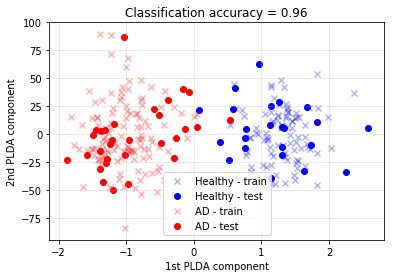

In [42]:
# Transform the training and testing data using our learned PLDA directions
Xtr_plda = plda.transform(Xtr_pca)
Xte_plda = plda.transform(Xte_pca)

# Plot the transformed data on a scatter plot
for lab,col,name in zip([0,1],['b','r'],['Healthy','AD']):
    plt.scatter(Xtr_plda[ytr==lab,0], Xtr_plda[ytr==lab,1], c=col, marker='x', alpha=0.3, label=name+' - train')
    plt.scatter(Xte_plda[yte==lab,0], Xte_plda[yte==lab,1], c=col, label=name+' - test')
plt.grid(alpha=0.3)
plt.xlabel('1st PLDA component')
plt.ylabel('2nd PLDA component')
plt.title('Classification accuracy = {:.2f}'.format(acc))
plt.legend()
plt.show()

### Visualizing the Results

To complete our comparison between classification in image space and Radon-CDT space, we can plot the mode of variation for the first PLDA component. This time, however, in order to reconstruct the mode of variation in image space (and not transport space), we must tell the `plot_mode_image()` function that we used the Radon-CDT. To achieve this, we set the `transform` and `img0` parameters in `plot_mode_image()`.

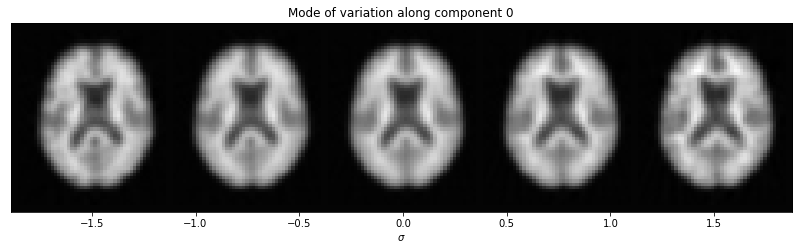

In [44]:
from optrans.continuous import RadonCDT

ax = plot_mode_image([pca, plda], component=0, shape=(h,w), transform=RadonCDT(), img0=img0, 
                     n_std=3, n_steps=5, cmap='gray', figsize=(14,4))
plt.show()

At first glance, the mode of variation along the first PLDA component looks very similar to the mode of variation from our analysis of the original brain images. However, it is evident from the higher classification accuracy that the PLDA classifier has learned more subtle differences between the two classes in transport space. This is particularly noticeable in the brain ventricles. The ventricles in the brain images above are similar in size. However, the ventricles in the mode of variation from our image space analysis change size; the "Alzheimer's" reconstructions have larger ventricles than the "healthy" reconstructions. Although ventricles can enlarge with Alzheimer's disease, the true difference between the Alzheimer's disease scans and healthy scans is in the pattern of the tracer PET tracer uptake. Diseased patients exhibit high tracer uptake (i.e. bright pixels) in both grey and white matter, whereas healthy people should only show high tracer uptake in the white matter. Our results suggest that the PLDA classifier in transport space has learned this distinction more thoroughly.

Finally, we can plot the histograms of the testing data projected on to the first PLDA component. The first component is the most discriminatory, so there is very little overlap in the histograms.

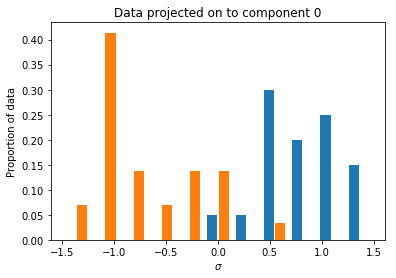

In [46]:
# Plot histogram of the test data projected on to the 1st PLDA component
ax = plot_mode_histogram(Xte_plda, y=yte, component=0, decomp=plda, n_bins=11)
plt.show()